# Data exploration

In [1]:
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from skimage import io
from tqdm import tqdm
from utils.data_exploration import *

# autoreload
%load_ext autoreload
%autoreload 2

# Get the current working directory
current_dir = os.getcwd()

# Define the path to the data
data_path = os.path.join(current_dir, 'data')

print(f"Data path: {data_path}")

Data path: c:\Users\lucha\Documents\GitHub\semester-project-global-warming\data


In [2]:
print("Loading the data...")
# Load the data
with open(os.path.join(data_path, 'ssp585_time_series.pkl'), 'rb') as f:
    data = pkl.load(f)

print("Data loaded successfully!")

Loading the data...
Data loaded successfully!


In [3]:
# Print the keys of the data (only the first 5)
print(f"Keys of the data: {list(data.keys())[:5]}")

Keys of the data: ['ICON-ESM-LR', 'EC-Earth3', 'EC-Earth3-Veg-LR', 'FIO-ESM-2-0', 'CMCC-CM2-SR5']


In [19]:
# Keep only models which have more than 4 runs (>= 4 runs)

filtered_data = {
    model: {run: np.flip(data[model][run], axis = 1) for run in data[model]}
    for model in data.keys() if len(data[model]) >= 4
}

## Plot a time stamp for a randomly chosen model

In [20]:
filtered_data.keys()

dict_keys(['ICON-ESM-LR', 'EC-Earth3', 'CMCC-CM2-SR5', 'ACCESS-CM2', 'CESM2', 'CNRM-ESM2-1', 'IPSL-CM6A-LR', 'GISS-E2-2-G', 'CNRM-CM6-1', 'CanESM5-1', 'E3SM-2-0-NARRM', 'HadGEM3-GC31-LL', 'MIROC-ES2L', 'GISS-E2-1-H', 'E3SM-2-0', 'GISS-E2-1-G', 'EC-Earth3-Veg', 'ACCESS-ESM1-5', 'HadGEM3-GC31-MM', 'FGOALS-g3', 'E3SM-1-0', 'MPI-ESM1-2-HR', 'CanESM5', 'CAS-ESM2-0', 'MIROC6', 'NESM3', 'GISS-E2-2-H', 'MPI-ESM1-2-LR', 'AWI-CM-1-1-MR', 'UKESM1-0-LL', 'NorCPM1', 'INM-CM5-0', 'MRI-ESM2-0', 'CESM2-FV2'])

In [21]:
# chose a key randomly
random_model = 'CanESM5-1'
random_model_data = filtered_data[random_model]
print(f"Randomly selected model: {random_model}, which has {len(random_model_data)} runs.")

Randomly selected model: CanESM5-1, which has 72 runs.


In [22]:
first_random_model_run = random_model_data[list(random_model_data.keys())[0]]
first_random_model_run.shape # Shape: (Time x Latitude x Longitude)

(165, 72, 144)

In [23]:
random_timestamp = random.randint(0, first_random_model_run.shape[0])
data_to_plot = first_random_model_run[random_timestamp, :, :]
print(f"Random timestamp: {random_timestamp}")

Random timestamp: 134


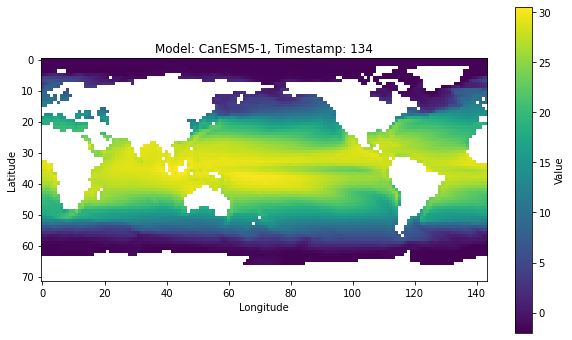

In [24]:
# Plot the data
# Create a colormap that sets NaN values to a specific color (e.g., gray)
plt.figure(figsize=(10, 6))
plt.imshow(data_to_plot, cmap='viridis') # Places the origin in the lower left
plt.colorbar(label='Value')
plt.title(f'Model: {random_model}, Timestamp: {random_timestamp}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Get a mask of all the grids where there is at least one NaN value (for all models and all runs)

In [25]:
grid_shape = filtered_data[list(filtered_data.keys())[0]][list(filtered_data[list(filtered_data.keys())[0]].keys())[0]].shape[1:]
nan_mask = np.zeros(grid_shape, dtype=bool)
print(f"The grid has a shape of: {nan_mask.shape}.")

The grid has a shape of: (72, 144).


In [26]:
for model in tqdm(filtered_data):
    for run in filtered_data[model]:
        nan_mask = nan_mask | np.any(np.isnan(filtered_data[model][run]), axis = 0)

100%|██████████| 34/34 [00:52<00:00,  1.54s/it]


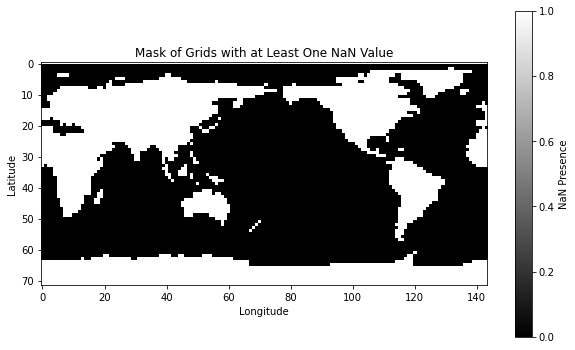

In [27]:
# Plot the mask
plt.figure(figsize=(10, 6))
plt.imshow(nan_mask, cmap='gray')
plt.colorbar(label='NaN Presence')
plt.title('Mask of Grids with at Least One NaN Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Remove all grid cells that contain at least one NaN

In [28]:
for model in tqdm(filtered_data):
    for run in filtered_data[model]:
        filtered_data[model][run][:, nan_mask] = np.nan

100%|██████████| 34/34 [00:07<00:00,  4.41it/s]


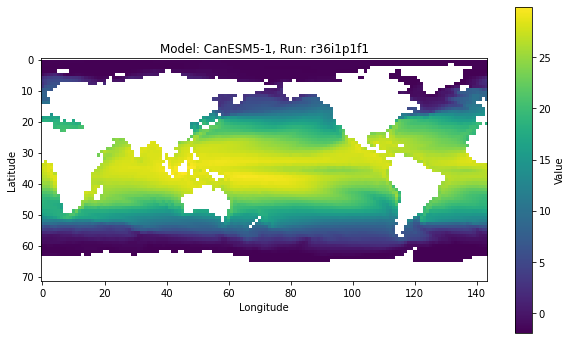

In [38]:
# Example of plotting a random run after applying the NaN filter
random_model = 'CanESM5-1'
random_run = random.choice(list(filtered_data[random_model].keys()))
data_to_plot = filtered_data[random_model][random_run]

# Plot the data
plt.figure(figsize=(10, 6))
plt.imshow(data_to_plot[0, :, :], cmap='viridis')  # Plotting the first time step as an example
plt.colorbar(label='Value')
plt.title(f'Model: {random_model}, Run: {random_run}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Centering of the data for each cell

In [67]:
# Centering the data

centered_data = {}

for model in tqdm(filtered_data):
    
    # Stack all the runs together along a new axis
    runs_stack = np.stack([filtered_data[model][run] for run in filtered_data[model]], axis=0)
    
    grid_average = np.nanmean(runs_stack, axis = (0,1))
    
    
    # Center the grid data
    centered_data[model] = {run: filtered_data[model][run] - grid_average for run in filtered_data[model]}
    
    # Calculate the forced response as the average of the centered runs
    forced_response = np.nanmean(np.stack(list(centered_data[model].values()), axis = 0),axis = 0)
    
    centered_data[model]['forced_response'] = forced_response

  0%|          | 0/34 [00:00<?, ?it/s]C:\Users\lucha\AppData\Local\Temp\ipykernel_9116\3381025783.py:10: RuntimeWarning: Mean of empty slice
  grid_average = np.nanmean(runs_stack, axis = (0,1))
C:\Users\lucha\AppData\Local\Temp\ipykernel_9116\3381025783.py:17: RuntimeWarning: Mean of empty slice
  forced_response = np.nanmean(np.stack(list(centered_data[model].values()), axis = 0),axis = 0)
100%|██████████| 34/34 [02:05<00:00,  3.70s/it]


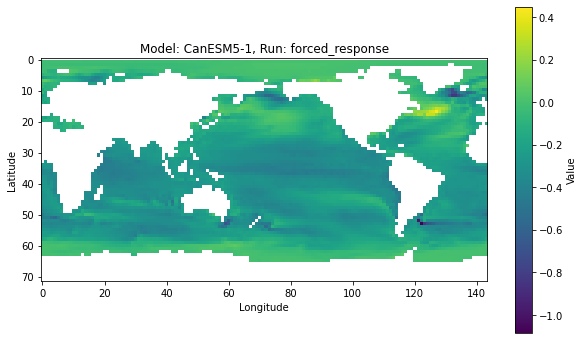

In [68]:
# Example of plotting a random run after applying the NaN filter
example_model = 'CanESM5-1' # Same as the example one
random_run = random.choice(list(centered_data[example_model].keys()))
data_to_plot = centered_data[example_model][random_run]

# Plot the data
plt.figure(figsize=(10, 6))
plt.imshow(data_to_plot[0, :, :], cmap='viridis')  # Plotting the first time step as an example
plt.colorbar(label='Value')
plt.title(f'Model: {example_model}, Run: {random_run}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Displaying the forced response and runs for grid spot: [26 62]


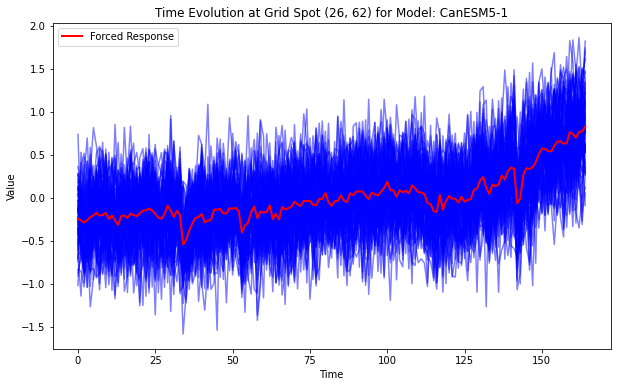

In [81]:
# Example of plotting the forced response for a random model
example_model = 'CanESM5-1' # Same as the example one
valid_grid_spots = np.argwhere(~nan_mask)
random_grid_spot = valid_grid_spots[random.randint(0, len(valid_grid_spots))]
print(f"Displaying the forced response and runs for grid spot: {random_grid_spot}")

# Data for each run
time_series_data = {run : centered_data[example_model][run][:, random_grid_spot[0], random_grid_spot[1]] for run in centered_data[example_model]}
forced_response_data = centered_data[example_model]['forced_response'][:, random_grid_spot[0], random_grid_spot[1]]

# Plot the time series data for all runs and the forced response
plt.figure(figsize=(10, 6))
for data in time_series_data.values():
    plt.plot(data, color='blue', alpha=0.5)
plt.plot(forced_response_data, color='red', label='Forced Response', linewidth=2)
plt.title(f'Time Evolution at Grid Spot ({random_grid_spot[0]}, {random_grid_spot[1]}) for Model: {example_model}')
plt.xlabel('Time') # Need to change this
plt.ylabel('Value')
# plt.ylim(-2,4)
plt.legend()
plt.show()